In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score,KFold
from sklearn import tree
from scipy.stats import chi2_contingency

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

In [3]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [4]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,1


In [5]:
contingency_table = pd.crosstab(train_df['Sex'], train_df['Title'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(p)

4.448184462993702e-189


In [6]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

In [7]:
guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [8]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 7)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 11.429]",0.573529
1,"(11.429, 22.857]",0.409756
2,"(22.857, 34.286]",0.314448
3,"(34.286, 45.714]",0.426829
4,"(45.714, 57.143]",0.411765
5,"(57.143, 68.571]",0.346154
6,"(68.571, 80.0]",0.142857


In [9]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 7)

age_stats = (
    train_df.groupby('AgeBand')
    .agg(
        Survived_mean=('Survived', 'mean'),
        Count=('Survived', 'size')
    )
    .reset_index()
    .sort_values(by='AgeBand')
)

print(age_stats)

            AgeBand  Survived_mean  Count
0   (-0.08, 11.429]       0.573529     68
1  (11.429, 22.857]       0.409756    205
2  (22.857, 34.286]       0.314448    353
3  (34.286, 45.714]       0.426829    164
4  (45.714, 57.143]       0.411765     68
5  (57.143, 68.571]       0.346154     26
6    (68.571, 80.0]       0.142857      7


In [10]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 23), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 23) & (dataset['Age'] <= 34), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 34) & (dataset['Age'] <= 46), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 46) & (dataset['Age'] <= 57), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 57) & (dataset['Age'] <= 69), 'Age'] = 5
    dataset.loc[ dataset['Age'] > 69, 'Age'] = 6

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,3,1,0,71.2833,C,3
2,1,3,1,2,0,0,7.9250,S,2
3,1,1,1,3,1,0,53.1000,S,3
4,0,3,0,3,0,0,8.0500,S,1


In [11]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,3,71.2833,1,3,0,3
2,1,3,1,2,7.9250,0,2,1,6
3,1,1,1,3,53.1000,0,3,0,3
4,0,3,0,3,8.0500,0,1,1,9


In [12]:
fare0 = (train_df['Fare'] == 0).sum()
print(fare0)

15


In [13]:

train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.nan
test_df.loc[test_df['Fare'] == 0, 'Fare'] = np.nan

for dataset in [train_df, test_df]:
    dataset['Fare'] = dataset.groupby(['Pclass', 'Embarked'])['Fare'].transform(lambda x: x.fillna(x.median()))

In [14]:
fare0 = (train_df['Fare'] == 0).sum()
print(fare0)

0


In [15]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 5)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(4.010999999999999, 7.896]",0.206731
1,"(7.896, 11.242]",0.253333
2,"(11.242, 23.0]",0.416667
3,"(23.0, 41.579]",0.426136
4,"(41.579, 512.329]",0.627119


In [16]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 5)

fare_stats = (
    train_df.groupby('FareBand')
    .agg(
        Survived_mean=('Survived', 'mean'),
        Total=('Survived', 'size')
    )
    .reset_index()
    .sort_values(by='FareBand')
)

print(fare_stats)

                     FareBand  Survived_mean  Total
0  (4.010999999999999, 7.896]       0.206731    208
1             (7.896, 11.242]       0.253333    150
2              (11.242, 23.0]       0.416667    180
3              (23.0, 41.579]       0.426136    176
4           (41.579, 512.329]       0.627119    177


In [17]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 7)

fare_stats = (
    train_df.groupby('FareBand')
    .agg(
        Survived_mean=('Survived', 'mean'),
        Total=('Survived', 'size')
    )
    .reset_index()
    .sort_values(by='FareBand')
)

print(fare_stats)

                     FareBand  Survived_mean  Total
0  (4.010999999999999, 7.775]       0.219858    141
1               (7.775, 8.05]       0.203008    133
2                (8.05, 13.0]       0.335664    143
3              (13.0, 19.967]       0.397849     93
4            (19.967, 28.918]       0.436508    126
5            (28.918, 56.929]       0.445312    128
6           (56.929, 512.329]       0.685039    127


In [18]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.775, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.775)  & (dataset['Fare'] <= 8.050),   'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 8.050)  & (dataset['Fare'] <= 13.000),  'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 13.000) & (dataset['Fare'] <= 19.967),  'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 19.967) & (dataset['Fare'] <= 28.918),  'Fare'] = 4
    dataset.loc[(dataset['Fare'] > 28.918) & (dataset['Fare'] <= 56.929),  'Fare'] = 5
    dataset.loc[ dataset['Fare'] > 56.929,                                'Fare'] = 6
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]   
    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,3,6,1,3,0,3
2,1,3,1,2,1,0,2,1,6
3,1,1,1,3,5,0,3,0,3
4,0,3,0,3,1,0,1,1,9


In [19]:
print(train_df['Survived'].value_counts())
print(train_df['Survived'].value_counts(normalize=True) * 100)

0    549
1    342
Name: Survived, dtype: int64
0    61.616162
1    38.383838
Name: Survived, dtype: float64


In [20]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

### Decision Tree

In [21]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

### DT - Hyperparameter Tuning using GridSearch

In [22]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4,5],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_dt.fit(X_train, Y_train)
best_dt = grid_dt.best_estimator_
print(grid_dt.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


### Decision Tree Plot

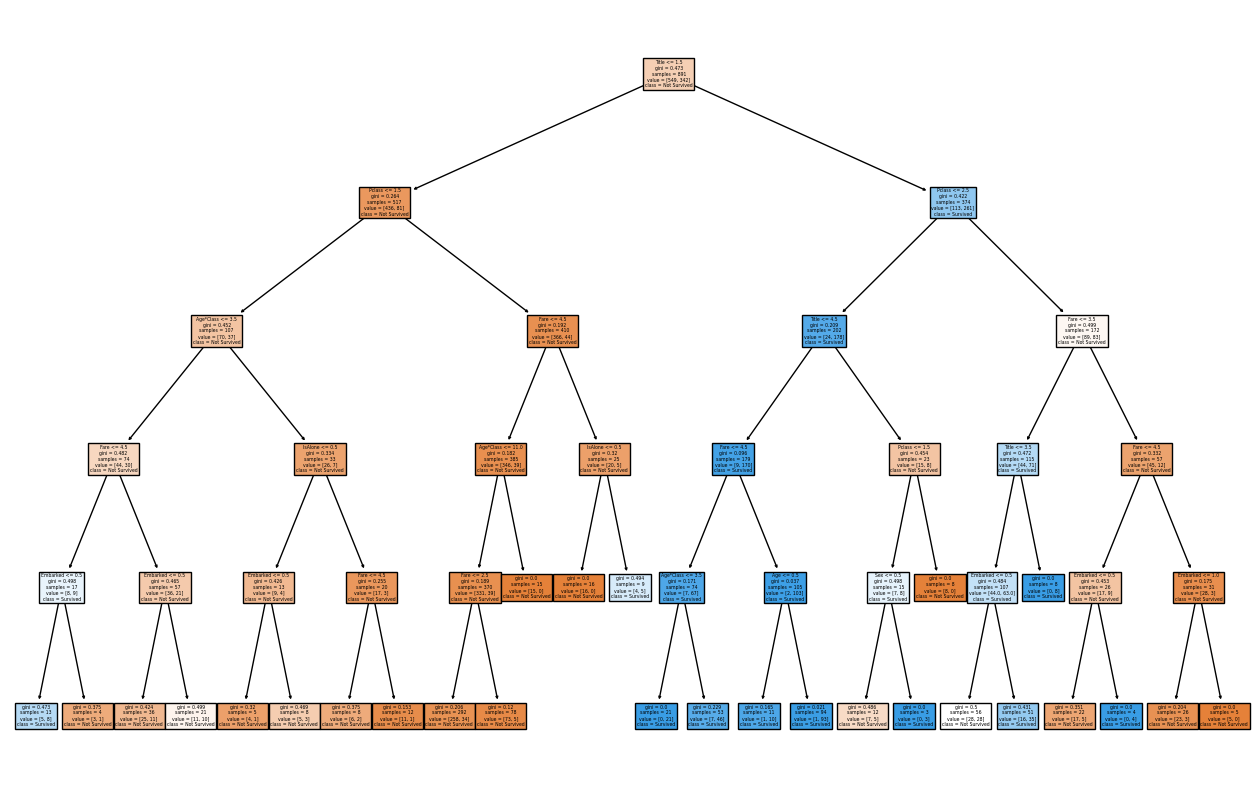

In [23]:
plt.figure(figsize=(16, 10))
tree.plot_tree(best_dt, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.show()

### 5-fold Cross Validation

In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_dt, X_train, Y_train, cv=cv, scoring="accuracy", n_jobs=-1)

print(cv_scores)
print(cv_scores.mean())

[0.81005587 0.81460674 0.86516854 0.79213483 0.83707865]
0.8238089259933463


### Random Forest

In [25]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [26]:
param_grid = {
    "n_estimators": [100,200,300],
    "max_depth": [None,4,5,6,7],
    "min_samples_split": [2,3,4,5,6,7,8],
    "min_samples_leaf": [3,4,5,6],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid_rf.fit(X_train, Y_train)
best_rf = grid_rf.best_estimator_
print(grid_rf.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [27]:
rf_cv_scores = cross_val_score(best_rf, X_train, Y_train, cv=cv, scoring="accuracy", n_jobs=-1)

print(rf_cv_scores)
print(rf_cv_scores.mean())

[0.82681564 0.81460674 0.87078652 0.81460674 0.84831461]
0.8350260498399347


Decision Tree's average accuracy for five-fold cross validation is 0.8238 and Random Forest's average accuracy for five-fold cross validation is 0.8350. As we can see, Random Forest's average accuracy for five-fold cross validation is better.
<br/>
Random Forest is an ensemble model that trains multiple decision trees with bootstrap samples and averages the predictions, it reduce overfitting and Improves generalization performance. But Decision tree is high variance model, that prediction can change alot even data has changed little. It shows relatively unstable performance.
<br/>
Random Forests demonstrate higher accuracy in cross-validation than Decision Trees. They also shows better generalization performance. So, Random Forest is more appropriate model at this Titanic classification problem, 